In [140]:
# In this notebook, you learn:
# 
# 1) How to train the model using the names dataset to build a name generator?
#
# Resources:
# 1) https://youtu.be/TCH_1BHY58I?si=m65oyEMLQ5OXBjjA
#       -- Andrej Karpathy's video on makemore which is used to build the model.
# 2) https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
#       -- Bengio et al. (2003) paper on A Neural Probabilistic Language Model
#       -- This paper is the basis for the model we are building. Watch the video first and then read the paper.
# 3) https://brandonmorris.dev/2018/06/24/mastering-the-learning-rate/
#       -- Brandon Morris's blog on learning rates.
#       -- We won't exactly be using the learning rate schedulers as mentioned in the blog, but it gives a good
#          intuition on how to choose the learning rate in general. We will the general idea to perform experiments
#          to find the best learning rate for our model.
# 4) https://arxiv.org/pdf/1506.01186
#       -- Leslie Smith's in which Learning Rate Range Test was first introduced.
# 5) https://blog.dataiku.com/the-learning-rate-finder-technique-how-reliable-is-it
#       -- Dataiku's blog on the reliability of the learning rate finder technique.
#       -- Also, explans a few recommendations on finding optimal bounds for the learning rate.

In [141]:
import matplotlib.pyplot as plt
import string
import torch
import torch.nn.functional as F

from torch import Tensor
from typing import Dict, List, Tuple

In [142]:
# Number of characters used as input to the model.
BLOCK_SIZE = 3
# vocab size is the number of characters (26 alphabets + '.') represented as embeddings.
VOCAB_SIZE = 27
# Number of neurons in the hidden layer.
NUM_HIDDEN_NEURONS = 100
# Dimension of the embedding vectors representing the characters.
EMBEDDING_SIZE = 2
# Number of examples in a batch.
BATCH_SIZE = 32
# Path to the dataset used to train the model.
CLEANED_DATASET_PATH = '../../makemore_part1/Data/names.txt'
# Character to represent the end of a name.
BOUND_CHARACTER = '.'

In [143]:
SEED = 1234
g = torch.Generator().manual_seed(SEED)

In [193]:
def get_char_to_index_mapping() -> dict:
    char_to_index = {char: index + 1 for index, char in enumerate(string.ascii_lowercase)}
    char_to_index[BOUND_CHARACTER] = 0
    return char_to_index

def get_index_to_char_mapping() -> dict:
    index_to_char = {index + 1: char for index, char in enumerate(string.ascii_lowercase)}
    index_to_char[0] = BOUND_CHARACTER
    return index_to_char

In [145]:
# EVERYTHING IN THIS CELL HAS BEEN EXPLAINED IN THE PREVIOUS NOTEBOOKS. PLEASE REFER TO THEM FOR MORE DETAILS.
def get_data_from_file() -> List[str]:
    with open(CLEANED_DATASET_PATH, 'r') as f:
        names = [name.strip() for name in f.readlines()]
    return names


def extract_inputs_and_targets(names: str) -> Tuple[List[List[int]], List[int]]:
    char_to_index = get_char_to_index_mapping()
    inputs = []
    targets = []
    for name in names:
        bounded_name = name + BOUND_CHARACTER
        current_block = [0] * BLOCK_SIZE
        for current_char in bounded_name:
            target_char_idx = char_to_index[current_char]
            inputs.append(current_block)
            targets.append(target_char_idx)
            current_block = current_block[1:]
            current_block.append(target_char_idx)
    return inputs, targets


def get_split_info(total_size: int) -> Tuple[int, int]:
    """Returns the indices to split the data into train, validation and test sets.

    Args:
        total_size (int): Total number of examples in the dataset.

    Returns:
        Tuple[int, int]: train_end, valid_end
                         train_end -- All the data between 0 and train_end is used for training.
                         valid_end -- All the data between train_end and valid_end is used for validation.
    """
    train_end = int(0.8 * total_size)
    valid_end = train_end + int(0.1 * total_size)
    return train_end, valid_end


def get_data_splits() -> Tuple[Tensor, Tensor, Tensor, Tensor, Tensor, Tensor]:
    names = get_data_from_file()
    inputs, targets = extract_inputs_and_targets(names)
    train_end, valid_end = get_split_info(len(inputs))
    
    X_train, Y_train = inputs[:train_end], targets[:train_end]
    X_train = torch.tensor(data=X_train, dtype=torch.int32)
    Y_train = torch.tensor(data=Y_train, dtype=torch.int32)

    X_valid, Y_valid = inputs[train_end:valid_end], targets[train_end:valid_end]
    X_valid = torch.tensor(data=X_valid, dtype=torch.int32)
    Y_valid = torch.tensor(data=Y_valid, dtype=torch.int32)
    
    X_test, Y_test = inputs[valid_end:], targets[valid_end:]
    X_test = torch.tensor(data=X_test, dtype=torch.int32)
    Y_test = torch.tensor(data=Y_test, dtype=torch.int32)

    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [ ]:
# EVERYTHING IN THIS CELL HAS BEEN EXPLAINED IN THE PREVIOUS NOTEBOOKS. PLEASE REFER TO THEM FOR MORE DETAILS.
def create_model_parameters(embedding_size: int=EMBEDDING_SIZE, num_hidden_neurons: int=NUM_HIDDEN_NEURONS) -> Dict[str, Tensor]:
    C = torch.randn(size=(VOCAB_SIZE, embedding_size), requires_grad=True, generator=g)
    W1 = torch.randn(size=(BLOCK_SIZE * embedding_size, num_hidden_neurons), requires_grad=True, generator=g)
    b1 = torch.randn(size=(num_hidden_neurons,), requires_grad=True, generator=g)
    W2 = torch.randn(size=(num_hidden_neurons, VOCAB_SIZE), requires_grad=True, generator=g)
    b2 = torch.randn(size=(VOCAB_SIZE,), requires_grad=True, generator=g)
    return {'C': C, 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}


def update_model_parameters(parameters: Dict[str, Tensor], learning_rate: float):
    for parameter in parameters.values():
        parameter.data += -learning_rate * parameter.grad
        parameter.grad = None


def forward(parameters: Dict[str, Tensor], X: Tensor) -> Tensor:
    # Retrieve the embeddings for the characters in the input.
    X_inp = parameters['C'][X]
    # -1 corresponds to the unknown batch size.
    X_inp = X_inp.view(-1, BLOCK_SIZE * EMBEDDING_SIZE)
    hidden_outputs = torch.tanh(X_inp @ parameters['W1'] + parameters['b1'])
    logits = hidden_outputs @ parameters['W2'] + parameters['b2']
    return logits


def compute_loss(logits: Tensor, Y_target: Tensor) -> Tensor:
    return F.cross_entropy(logits, Y_target.type(torch.long))


def backward(loss: Tensor) -> None:
    loss.backward()

## Training Loop

In [147]:
# Create the training, validation and test data splits.
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = get_data_splits()

In [148]:
# Create the model parameters for training.
parameters = create_model_parameters()
# Let's count the number of trainable parameters in the model.
num_trainable_parameters = sum(parameter.numel() for parameter in parameters.values())
print(f"Number of trainable parameters: {num_trainable_parameters}")

Number of trainable parameters: 3481


In [149]:
def training_loop(X_train: Tensor, 
                  Y_train: Tensor, 
                  num_epochs: int, 
                  learning_rate: float, 
                  parameters: List[Tensor],
                  log_frequency: int=1) -> Tensor:
    """Trains the model on the provided dataset for the specified number of epochs.

    Args:
        X_train (Tensor): Input data for training.
        Y_train (Tensor): Target data for training.
        num_epochs (int): Number of epochs to train the model for.
        learning_rate (float): Learning rate used to update the model parameters.
        parameters (List[Tensor]): Parameters of the model.
        log_frequency (int): Frequency at which the loss is logged.
    """
    loss = None
    for epoch in range(num_epochs):
        # Forward pass
        logits = forward(parameters, X_train)
        loss = compute_loss(logits, Y_train)
        # Backward pass
        backward(loss)
        # Update the parameters
        update_model_parameters(parameters, learning_rate)
        # Log the loss every few iterations.
        if (epoch + 1) % log_frequency == 0:
            print(f"epoch: {epoch}, learning_rate: {learning_rate} Loss: {loss.item()}")
    return loss

In [150]:
# Let's run the training loop a few times with different learning rates to see find some bounds.
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=10, parameters=parameters)
print("-" * 100)
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=1, parameters=parameters)
print("-" * 100)
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=0.1, parameters=parameters)
print("-" * 100)
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=0.01, parameters=parameters)
print("-" * 100)
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=0.001, parameters=parameters)
print("-" * 100)
training_loop(X_train=X_train, Y_train=Y_train, num_epochs=10, learning_rate=0.0001, parameters=parameters)

epoch: 0, learning_rate: 10 Loss: 17.356292724609375
epoch: 1, learning_rate: 10 Loss: 117.19644927978516
epoch: 2, learning_rate: 10 Loss: 177.57545471191406
epoch: 3, learning_rate: 10 Loss: 143.7162628173828
epoch: 4, learning_rate: 10 Loss: 75.18205261230469
epoch: 5, learning_rate: 10 Loss: 61.3066520690918
epoch: 6, learning_rate: 10 Loss: 61.786399841308594
epoch: 7, learning_rate: 10 Loss: 55.72304916381836
epoch: 8, learning_rate: 10 Loss: 51.55561828613281
epoch: 9, learning_rate: 10 Loss: 56.11006546020508
----------------------------------------------------------------------------------------------------
epoch: 0, learning_rate: 1 Loss: 41.16244888305664
epoch: 1, learning_rate: 1 Loss: 36.5606689453125
epoch: 2, learning_rate: 1 Loss: 32.88502883911133
epoch: 3, learning_rate: 1 Loss: 29.8353328704834
epoch: 4, learning_rate: 1 Loss: 27.310256958007812
epoch: 5, learning_rate: 1 Loss: 25.247243881225586
epoch: 6, learning_rate: 1 Loss: 23.574100494384766
epoch: 7, learning

tensor(18.5561, grad_fn=<NllLossBackward0>)

## Learning Rate

In [151]:
# Looking at the above sample runs, it seems learning rate of 10 is too high and the model diverges.
# Learning rate of 1 seem to be good since the loss is decreasing but it is still high.
# Learning rate of 0.0001 seems to be very very low since the loss is decreasing extremely slowly (Plateau).
# Learning rate of 0.01 itself seems to be a bit low since the loss is decreasing slowly but still workable. 
# In general, we use Learning rate range test (LRRT) to find reasonable bounds for the learning rate.
# It is also used sometimes to find an optimal learning rate to use in some cases.

In [152]:
# The standard practice is to iterate over the learning rates in the exponentiated space. One of the reasoning to do
# this is that if we iterate over the learning rates linearly, the learning rates are too close to each other to 
# give any meaningful results and most of the computation is wasted on learning rates that are not useful. So, we 
# iterate over the exponentiated space to get a good idea of the learning rates that are useful.
# -7 corresponds to a learning rate of 10^-7
# 0 corresponds to a learning rate of 10^0
learning_rate_exponents = torch.linspace(start=-7, end=0.5, steps=10000)
learning_rates = 10 ** learning_rate_exponents
print(f"Number of learning rates to try: {len(learning_rates)}")
print(f"First 10 learning rates: {learning_rates[:10]}")

Number of learning rates to try: 10000
First 10 learning rates: tensor([1.0000e-07, 1.0017e-07, 1.0035e-07, 1.0052e-07, 1.0069e-07, 1.0087e-07,
        1.0104e-07, 1.0122e-07, 1.0139e-07, 1.0157e-07])


In [153]:
# To find an optimal learning rate, we will run the training loop for each of the learning rates and plot the loss.
# This will help us understand how the loss changes with respect to the learning rate and help us find the optimal.
# Also, let's use mini-batches instead of the entire dataset to speed up the experiments. First let me show how to
# create mini-batches and then we will run the experiments.
batch_indices = torch.randint(low=0, high=X_train.size(0), size=(BATCH_SIZE,))
print(f"Randomly selected indices to be included in the batch for training: {batch_indices}")
print("-" * 100)
# We simply index the training data using the sampled batch indices to get the mini-batch.
X_train_batch = X_train[batch_indices]
print(f"Input data in the batch: {X_train_batch}")
print("-" * 100)

Randomly selected indices to be included in the batch for training: tensor([296571, 390935,  84199, 193804, 314540, 408097, 135938, 422347,  43094,
         60897, 313741,  43955,   8175, 321726,   9306, 269704, 183566,  38023,
        321337, 113231, 310899, 184683, 395143, 402160, 230312, 330408, 374945,
         32156, 223490, 119280, 319538,   6143])
----------------------------------------------------------------------------------------------------
Input data in the batch: tensor([[ 2,  1, 14],
        [ 0,  0,  1],
        [ 8, 14,  1],
        [ 0,  0,  2],
        [ 1,  1, 14],
        [ 1, 19,  8],
        [ 9, 11,  1],
        [ 0, 11,  1],
        [14,  7,  5],
        [ 0,  0, 12],
        [ 0,  0,  0],
        [ 0,  0, 14],
        [ 0, 26,  1],
        [ 9, 11,  1],
        [20,  8,  9],
        [ 0, 14,  9],
        [ 1, 11, 19],
        [18,  1, 14],
        [22,  1,  9],
        [ 9, 19,  1],
        [ 0,  0,  0],
        [ 1, 14, 20],
        [ 1, 18,  1],
        [ 1

In [154]:
# Create the model parameters for experiments.
exp_parameters = create_model_parameters()
# Holds the learning rates used for training. We are creating this list since matplotlib doesn't accept tensors.
lrs = []
# Holds the exponents of the learning rates used for training. Plotting the exponents might be easier to interpret.
lr_exps = []
# Holds the losses for each learning rate.
lr_losses = []
for idx in range(10000):
    batch_indices = torch.randint(low=0, high=X_train.size(0), size=(BATCH_SIZE,))
    X_train_batch = X_train[batch_indices]
    Y_train_batch = Y_train[batch_indices]
    loss = training_loop(X_train=X_train_batch, 
                         Y_train=Y_train_batch, 
                         num_epochs=1, 
                         learning_rate=learning_rates[idx].item(), 
                         parameters=exp_parameters, 
                         log_frequency=100)
    lr_exps.append(learning_rate_exponents[idx].item())
    lrs.append(learning_rates[idx].item())
    lr_losses.append(loss.item())

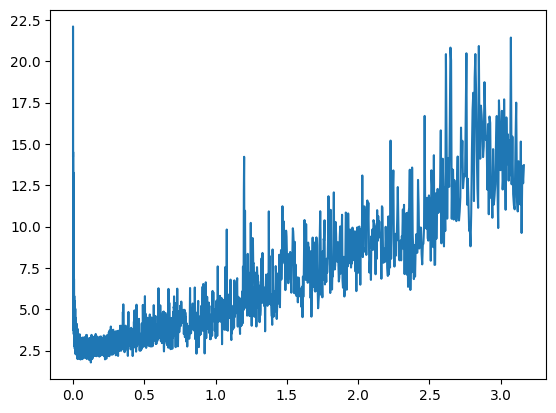

In [155]:
# Plotting the loss with respect to the learning rates.
plt.plot(lrs, lr_losses)

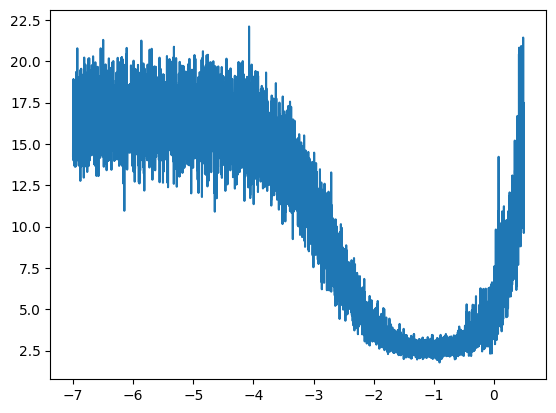

In [156]:
# I don't fully understand the reasoning behind the recommendations to select the learning rate bounds using this plot.
# 
# Nevertheless, the recommendations are as follows:
# 1) The recommended minimum learning rate is the value where the loss decreases the fastest (minimum negative gradient).
# 2) The recommended maximum learning rate is 10 times less than the learning rate where the loss is minimum.
#       -- The reasoning here is that loss stopped decreasing at the minimum point and so it is probably too high. So,
#          we take a step back and pick the learning rate that is 10 times less than the minimum point.
# 3) If you want to use a single learning rate, you can use the learning rate where the loss is minimum.
#       -- The reasoning here is that learning rate corresponding to the minimum loss is often considered optimal because 
#          it represents the point where training progresses efficiently without divergence.
# 
# I understand that points 2 and 3 are a bit contradictory. Andrej recommends point 3 in his video but the two blogs 
# added above recommend point 2. For now, let's going with the recommendations of Andrej and pick the learning rate of 1.
#
# Plotting the loss with respect to the exponents of the learning rates.
plt.plot(lr_exps, lr_losses)

This below image is the expectation on how the LRRT plot looks like. The learning rate is too low initially and so <br>
we are in a loss plateau region. Then the loss starts decreasing and the rate at which it drops increases and then <br>
eventually moves to a region where the loss increases and kind of explodes when the learning rate is too high. <br> 
This agrees with the above plot.

<img src="../Data/Images/LearningRateRangeTest.png" alt="name_prediction_neural_network" width="500" height="400">

## Model Training

In [171]:
def compute_validation_loss(X_valid: Tensor, Y_valid: Tensor, parameters: List[Tensor]) -> Tensor:
    logits = forward(parameters, X_valid)
    validation_loss = compute_loss(logits, Y_valid)
    return validation_loss

In [181]:
# Creating fresh model parameters for training so that the above experiments don't affect the training.
train_params_1 = create_model_parameters()

In [182]:
# Getting the total data so that we can compute the loss on the entire dataset to compare it with the models
# built in makemore1. 
# We shouldn't be doing this normally but since we are just experimenting, it is fine. We should never ever
# touch the test data until the very data. Otherwise, our model will overfit to the test data since our 
# training decisions are based on the test data.
X = torch.concatenate((X_train, X_valid, X_test), dim=0)
print(f"X shape: {X.shape}")
print(f"X[:10]: {X[:10]}")
Y = torch.concatenate((Y_train, Y_valid, Y_test), dim=0)

X shape: torch.Size([545276, 3])
X[:10]: tensor([[ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 12],
        [ 1, 12,  2],
        [12,  2, 15],
        [ 2, 15, 14],
        [15, 14, 19],
        [14, 19,  8],
        [19,  8,  1],
        [ 0,  0,  0]], dtype=torch.int32)


In [188]:
train_loss = None
validation_loss = None
# Let's train the model here.
for i in range(50000):
    batch_indices = torch.randint(low=0, high=X_train.size(0), size=(BATCH_SIZE,))
    X_train_batch = X_train[batch_indices]
    Y_train_batch = Y_train[batch_indices]
    train_loss = training_loop(X_train=X_train_batch, Y_train=Y_train_batch, num_epochs=1, learning_rate=0.01, parameters=train_params_1, log_frequency=1000)
    if i % 5000 == 0:
        print(f"Train Loss after iteration {i + 1}: {train_loss.item()}")
        validation_loss = compute_validation_loss(X_valid, Y_valid, train_params_1)
        print(f"Validation Loss after iteration {i + 1}: {validation_loss.item()}")
        print("-" * 100)

# Let's print the final train and validation losses. 
print(f"Train Loss at end of training: {train_loss.item()}")
print(f"Validation Loss at end of training: {validation_loss.item()}")
print("-" * 100)
# Let's also calculate the loss on the entire dataset to compare it with the models built in makemore1.
total_loss = compute_validation_loss(X, Y, train_params_1)
print(f"Loss on the entire dataset: {total_loss.item()}")

Train Loss after iteration 1: 1.5850889682769775
Validation Loss after iteration 1: 2.1101198196411133
----------------------------------------------------------------------------------------------------
Train Loss after iteration 5001: 1.4878473281860352
Validation Loss after iteration 5001: 2.1106278896331787
----------------------------------------------------------------------------------------------------
Train Loss after iteration 10001: 2.2000207901000977
Validation Loss after iteration 10001: 2.110602855682373
----------------------------------------------------------------------------------------------------
Train Loss after iteration 15001: 1.8397419452667236
Validation Loss after iteration 15001: 2.1098830699920654
----------------------------------------------------------------------------------------------------
Train Loss after iteration 20001: 1.9838229417800903
Validation Loss after iteration 20001: 2.1091370582580566
----------------------------------------------------

In [ ]:
# The best loss I could get was `2.10` with the model trained for 50000 iterations. This is lesser than what I got
# with the model built in makemore1. I trained the model for
# 1) 50000 iterations with a learning rate of 1
# 2) 50000 iterations with a learning rate of 0.1
# 3) 50000 iterations with a learning rate of 0.01

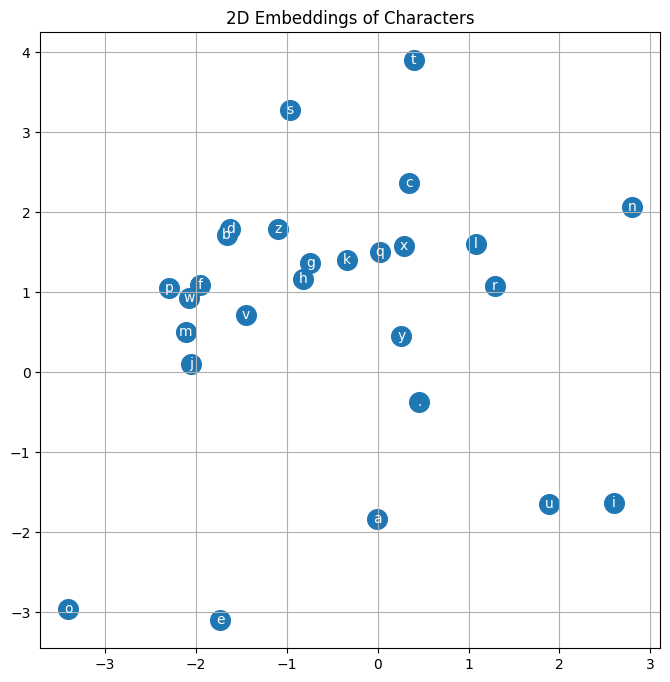

In [ ]:
# Now, let's plot the embeddings of the characters to see if we can find any patterns in the embeddings.
# Andrej found an interesting pattern where the vowels were clustered together. Let's see if we can find anything 
# interesting.
# Of course, we can't expect the same results but it seems like all the vowels are clustered together at the bottom
# of the plot.

index_to_char = get_index_to_char_mapping()
# Retrieve the trained embeddings.
C_trained = train_params_1['C']

# Set the figure size.
plt.figure(figsize=(8,8))
# Scatter plot of the embeddings.
plt.scatter(C_trained[:,0].data, C_trained[:,1].data, s=200)
# Add the character labels to the plot.
for i in range(C_trained.shape[0]):
    plt.text(C_trained[i,0].item(), C_trained[i,1].item(), index_to_char[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.title("2D Embeddings of Characters")
plt.show()

## Hyperparameter Tuning

In [195]:
# Maybe the model could be improved by tuning certain parameters in our model. We have the following options:
# 1) Increase the number of hidden neurons.
# 2) Increase the size of the embeddings.
# 3) Increase the number of characters used as input to the model.
#
# Let's focus on 1 and 2 for now. We will increase the number of hidden neurons to 200 and the size of the 
# embeddings to 10 as Andrej did in his video. We will keep the number of characters used as input to the model 
# as 3.

In [198]:
# Create the model parameters with the updated architecture.
train_params_2 = create_model_parameters(num_hidden_neurons=200, embedding_size=10)

In [199]:
# Let's run the same training loop as above with the new parameters.
train_loss = None
validation_loss = None
# Let's train the model here.
for i in range(50000):
    batch_indices = torch.randint(low=0, high=X_train.size(0), size=(BATCH_SIZE,))
    X_train_batch = X_train[batch_indices]
    Y_train_batch = Y_train[batch_indices]
    train_loss = training_loop(X_train=X_train_batch, Y_train=Y_train_batch, num_epochs=1, learning_rate=1, parameters=train_params_2, log_frequency=1000)
    if i % 5000 == 0:
        print(f"Train Loss after iteration {i + 1}: {train_loss.item()}")
        validation_loss = compute_validation_loss(X_valid, Y_valid, train_params_2)
        print(f"Validation Loss after iteration {i + 1}: {validation_loss.item()}")
        print("-" * 100)

# Let's print the final train and validation losses. 
print(f"Train Loss at end of training: {train_loss.item()}")
print(f"Validation Loss at end of training: {validation_loss.item()}")
print("-" * 100)
# Let's also calculate the loss on the entire dataset to compare it with the models built in makemore1.
total_loss = compute_validation_loss(X, Y, train_params_2)
print(f"Loss on the entire dataset: {total_loss.item()}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (160x6 and 30x200)